In [1]:
import skipthought
import tensorflow as tf
import numpy as np
from skipthought import utils
import time
import math
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_integer('num_epochs', 10000, "Number of epochs.")
tf.app.flags.DEFINE_integer('batch_size', 128, "The size of batch.")
tf.app.flags.DEFINE_integer('num_hidden', 32, 'Hidden size of GRU cell.')
tf.app.flags.DEFINE_integer('embedding_size', 32, 'The size of word embeddings.')
tf.app.flags.DEFINE_integer('max_vocab_size', 100, 'Size of vocabulary. Most frequent words are used.')
# tf.app.flags.DEFINE_integer('bottleneck_size', 128, 'Size of bottleneck softmax. It avoids matrices from num_hidden to vocab_size.')
tf.app.flags.DEFINE_float('learning_rate', 0.05, "Initial learning rate.")
tf.app.flags.DEFINE_float('decay_rate', 1.0, "Exponential decay rate.")
tf.app.flags.DEFINE_float('grad_clip', 1500.0, "Value for gradient clipping.")

In [3]:
model = skipthought.SkipthoughtModel('lstm', FLAGS.num_hidden, FLAGS.embedding_size,
                                     FLAGS.max_vocab_size, FLAGS.learning_rate,
                                     FLAGS.decay_rate, FLAGS.grad_clip, 5)

In [4]:
def gen_batch():
    encoder_inputs = np.random.randint(1, FLAGS.max_vocab_size, size=(FLAGS.batch_size, 10))
    decoder_inputs = np.hstack((np.zeros(FLAGS.batch_size)[:, np.newaxis], encoder_inputs[:, ::2][:, :-1]))
    decoder_target = encoder_inputs[:, :-1:2]
    return encoder_inputs, decoder_inputs, decoder_target

In [5]:
batches = [gen_batch() for _ in range(100)]

In [6]:
def train(sess, verbose=1000):
    st = time.time()
    loss_history = []
    for e in range(FLAGS.num_epochs):
        for b in range(len(batches)):
            encoder_input, decoder_input, decoder_target = batches[b]
            seq_lengths = np.ones(FLAGS.batch_size) * encoder_input.shape[1]
            weights = np.ones_like(decoder_target)
            feed_dict = model._fill_feed_dict(encoder_input, seq_lengths, decoder_input, decoder_target, weights,
                                 decoder_input, decoder_target, weights)

            start_time = time.time()
            batch_loss, _ = sess.run([model.loss, model.train_op], feed_dict=feed_dict)
            batch_perplexity = math.exp(float(batch_loss)) if batch_loss < 300 else float("inf")
            end_time = time.time()
            
            loss_history.append(batch_loss)
#             if b % verbose == 0:
#                         print(
#                             "{}/{} (epoch {}), train_loss = {:.3f}, perplexity = {:.3f}, time/batch = {:.3f}" \
#                             .format(e * len(batches) + b,
#                                     FLAGS.num_epochs * len(batches),
#                                     e, batch_loss, batch_perplexity, end_time - start_time))
                    
        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(14, 10))

        plt.title("Training loss, epoch {}/{}".format(str(e+1), str(FLAGS.num_epochs)))
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % batch_loss)
        
    print(str(FLAGS.num_epochs), 'epochs trained for', time.time() - st)

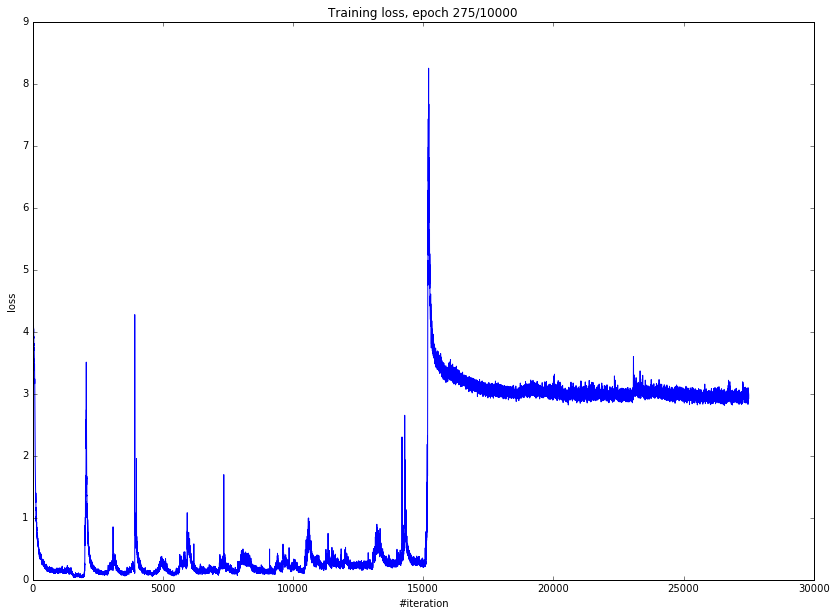

Current loss: 3.010260


KeyboardInterrupt: 

In [7]:
with tf.Session() as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    train(sess, verbose=1000)